In [1]:
import pandas as pd

# Load the data from the provided CSV
data = pd.read_csv('BostonHousing.csv')

# Display the first few rows of the dataframe to ensure it loaded correctly
data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [2]:
# Check for any missing values
data.isnull().sum()

# Basic statistics of the dataset
data.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [3]:
# Define the bins and labels for "RM"
bins = [0, 5, 6, 7, 8, 9]
labels = ['<5', '5-6', '6-7', '7-8', '8+']

# Add a new column 'RM_bin' to categorize 'RM' values into bins
data['RM_bin'] = pd.cut(data['rm'], bins=bins, labels=labels, right=False)


In [4]:
#MapReduce
def mapper(record):
    rm_value = record['rm']
    rm_bin = pd.cut([rm_value], bins=bins, labels=labels, right=False)[0]
    return (rm_bin, record)

# Apply the mapper function
mapped_data = data.apply(mapper, axis=1)
mapped_data

0      (6-7, [0.04741, 0.0, 11.93, 0, 0.573, 6.03, 80...
1      (6-7, [0.04741, 0.0, 11.93, 0, 0.573, 6.03, 80...
2      (7-8, [0.04741, 0.0, 11.93, 0, 0.573, 6.03, 80...
3      (6-7, [0.04741, 0.0, 11.93, 0, 0.573, 6.03, 80...
4      (7-8, [0.04741, 0.0, 11.93, 0, 0.573, 6.03, 80...
                             ...                        
501    (6-7, [0.04741, 0.0, 11.93, 0, 0.573, 6.03, 80...
502    (6-7, [0.04741, 0.0, 11.93, 0, 0.573, 6.03, 80...
503    (6-7, [0.04741, 0.0, 11.93, 0, 0.573, 6.03, 80...
504    (6-7, [0.04741, 0.0, 11.93, 0, 0.573, 6.03, 80...
505    (6-7, [0.04741, 0.0, 11.93, 0, 0.573, 6.03, 80...
Length: 506, dtype: object

In [5]:
#Reducer
from collections import defaultdict

def reducer(mapped_data):
    # Initialize a dictionary to store the results
    results = defaultdict(list)

    # Group data by RM_bin
    for bin_label, record in mapped_data:
        results[bin_label].append(record)

    # Calculate statistics for each bin
    stats = {}
    for bin_label, records in results.items():
        df = pd.DataFrame(records)
        stats[bin_label] = {
            'count': df.shape[0],
            'mean_medv': df['medv'].mean(),
            'median_medv': df['medv'].median(),
            'mean_rm': df['rm'].mean(),
            'median_rm': df['rm'].median()
        }

    return stats

# Apply the reducer function
statistics = reducer(mapped_data)
statistics


{'6-7': {'count': 269,
  'mean_medv': 11.900000000000002,
  'median_medv': 11.9,
  'mean_rm': 6.029999999999999,
  'median_rm': 6.03},
 '7-8': {'count': 51,
  'mean_medv': 11.9,
  'median_medv': 11.9,
  'mean_rm': 6.0299999999999985,
  'median_rm': 6.03},
 '5-6': {'count': 158,
  'mean_medv': 11.900000000000002,
  'median_medv': 11.9,
  'mean_rm': 6.03,
  'median_rm': 6.03},
 '8+': {'count': 13,
  'mean_medv': 11.900000000000002,
  'median_medv': 11.9,
  'mean_rm': 6.03,
  'median_rm': 6.03},
 '<5': {'count': 15,
  'mean_medv': 11.900000000000002,
  'median_medv': 11.9,
  'mean_rm': 6.03,
  'median_rm': 6.03}}

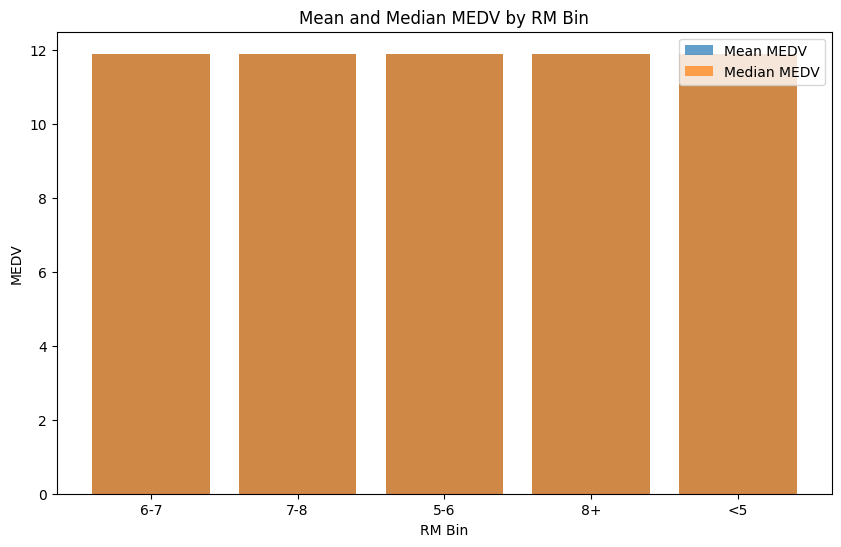

In [6]:
#Visualizations
import matplotlib.pyplot as plt

# Extract data for visualization
bins = list(statistics.keys())
mean_medv = [statistics[bin]['mean_medv'] for bin in bins]
median_medv = [statistics[bin]['median_medv'] for bin in bins]

# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(bins, mean_medv, alpha=0.7, label='Mean MEDV')
plt.bar(bins, median_medv, alpha=0.7, label='Median MEDV')
plt.xlabel('RM Bin')
plt.ylabel('MEDV')
plt.title('Mean and Median MEDV by RM Bin')
plt.legend()
plt.show()

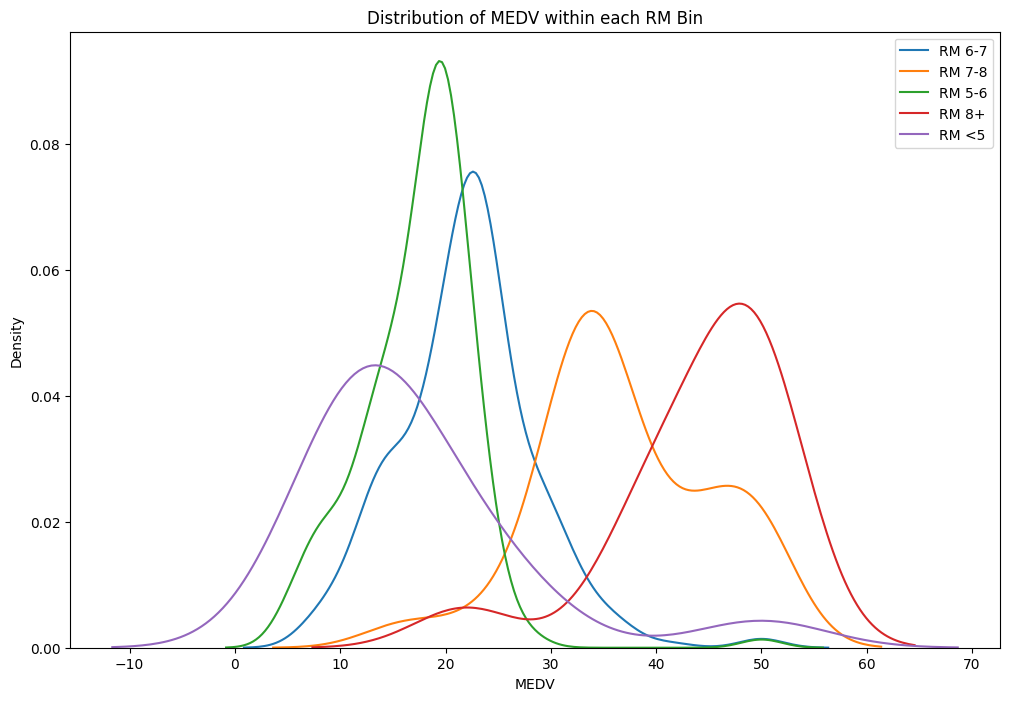

In [7]:
import seaborn as sns

# Create a distribution plot for each RM bin
plt.figure(figsize=(12, 8))
for bin_label in statistics.keys():
    sns.kdeplot(data[data['RM_bin'] == bin_label]['medv'], label=f'RM {bin_label}')

plt.xlabel('MEDV')
plt.ylabel('Density')
plt.title('Distribution of MEDV within each RM Bin')
plt.legend()
plt.show()

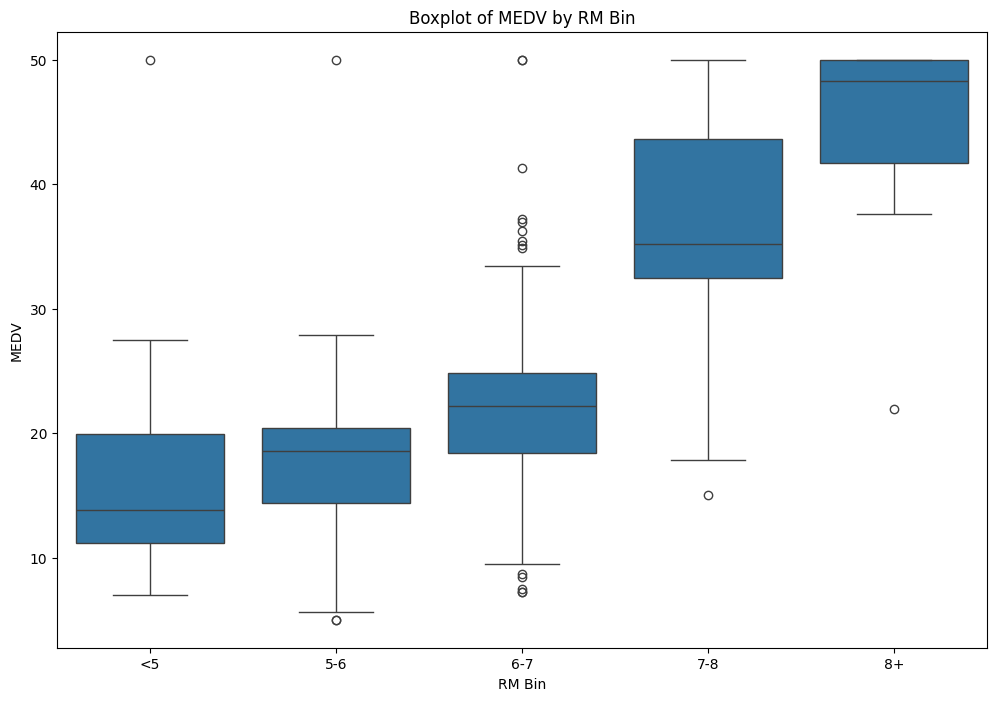

In [8]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='RM_bin', y='medv', data=data, order=labels)
plt.xlabel('RM Bin')
plt.ylabel('MEDV')
plt.title('Boxplot of MEDV by RM Bin')
plt.show()

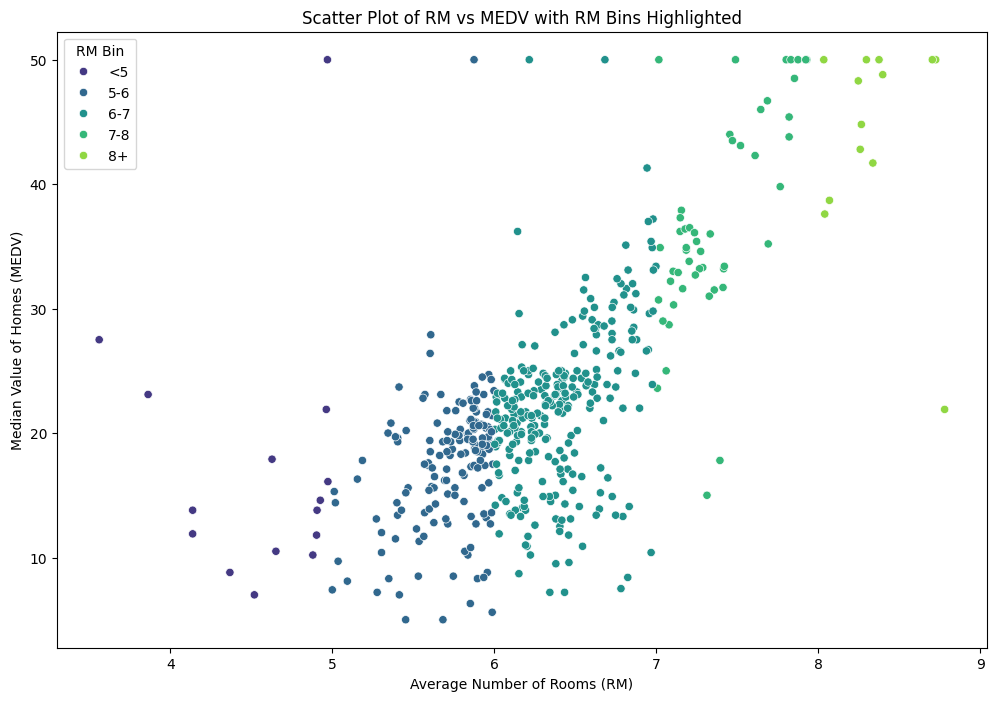

In [9]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='rm', y='medv', hue='RM_bin', data=data, palette='viridis')
plt.xlabel('Average Number of Rooms (RM)')
plt.ylabel('Median Value of Homes (MEDV)')
plt.title('Scatter Plot of RM vs MEDV with RM Bins Highlighted')
plt.legend(title='RM Bin')
plt.show()